## Cross-cancer prediction analysis

In [88]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

First, we want to see what happens when we train on a single gene in a single cancer type, and test on other single genes/cancer types. We expect to see good performance on the same gene/cancer type (since we're training and testing on the same data), and we're also hoping to see decent performance on the same gene in different cancer types.

In [127]:
# cross_cancer_dir = os.path.join(cfg.results_dir, 'cross_cancer', 'cross_cancer')
# cross_cancer_dir = os.path.join(cfg.repo_root, 'cross_cancer_random_results', 'cross_cancer_2')
cross_cancer_dir = os.path.join(cfg.repo_root, 'cross_cancer_brier', 'cross_cancer')
cross_cancer_df = au.load_prediction_results_cc(cross_cancer_dir, 'cross_cancer')
print(cross_cancer_df.shape)
cross_cancer_df.head()

(31545, 10)


,auroc,aupr,brier_score,weighted_brier_score,train_identifier,test_identifier,signal,seed,data_type,experiment
0,0.99982,0.999840,0.028269,0.028009,BRAF_SKCM,KRAS_UCEC,signal,42,train,cross_cancer
1,0.61958,0.220260,0.269390,0.252100,BRAF_SKCM,KRAS_UCEC,signal,42,test,cross_cancer
2,0.75789,0.773900,0.241180,0.244100,BRAF_SKCM,KRAS_UCEC,signal,42,cv,cross_cancer
0,1.00000,1.000000,0.024125,0.033606,TP53_READ,BRAF_LUAD,signal,42,train,cross_cancer
1,0.45259,0.085172,0.613420,0.372050,TP53_READ,BRAF_LUAD,signal,42,test,cross_cancer


In [90]:
# get rows that have the same identifier
cross_cancer_df['train_test_equal'] = (cross_cancer_df.train_identifier ==
                                       cross_cancer_df.test_identifier)
# get rows that have the same gene (possibly different cancer types)
cross_cancer_df['gene_equal'] = (cross_cancer_df.train_identifier.str.split('_', expand=True)[0] ==
                                 cross_cancer_df.test_identifier.str.split('_', expand=True)[0])

Text(0.5, 1.0, 'Cross-cancer performance, same train/test gene highlighted')

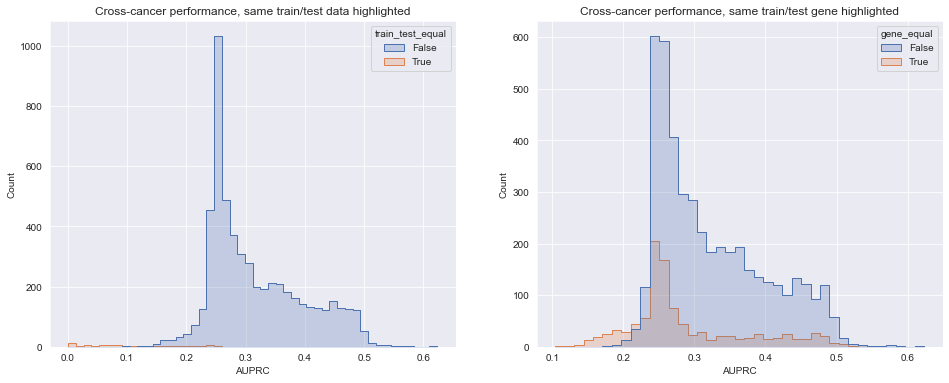

In [91]:
sns.set({'figure.figsize': (16, 6)})
fig, axarr = plt.subplots(1, 2)

sns.histplot(data=cross_cancer_df[(cross_cancer_df.signal == 'signal') &
                                  (cross_cancer_df.data_type == 'test')],
             x='weighted_brier_score', stat='count', hue='train_test_equal', element='step',
             kde=False, ax=axarr[0])
axarr[0].set_xlabel('AUPRC')
axarr[0].set_ylabel('Count')
axarr[0].set_title('Cross-cancer performance, same train/test data highlighted')
sns.histplot(data=cross_cancer_df[(cross_cancer_df.signal == 'signal') &
                                  (cross_cancer_df.data_type == 'test') &
                                  (~cross_cancer_df.train_test_equal)],
             x='weighted_brier_score', stat='count', hue='gene_equal', element='step',
             kde=False, ax=axarr[1])
axarr[1].set_xlabel('AUPRC')
axarr[1].set_ylabel('Count')
axarr[1].set_title('Cross-cancer performance, same train/test gene highlighted')

In [92]:
count_unique_ids = np.unique(cross_cancer_df.train_identifier).shape[0]
print(count_unique_ids)

75


In [125]:
heatmap_df, sorted_ids = au.heatmap_from_results(cross_cancer_df,
                                                 metric='aupr',
                                                 normalize_control=True,
                                                 sort_results=False)
# heatmap_df = 1 - heatmap_df # for brier score
heatmap_df.iloc[:5, :5]

test_identifier,BRAF_COAD,BRAF_LUAD,BRAF_SKCM,BRAF_THCA,KRAS_COAD
train_identifier,,,,,
BRAF_COAD,0.918456,-0.053447,-0.02909,0.05899,-0.08142
KRAS_COAD,-0.082027,0.012844,0.12545,0.06992,0.46983
KRAS_LUAD,0.165768,-0.014308,-0.03998,0.16837,0.16901
KRAS_PAAD,0.034692,-0.059559,-0.05123,0.26888,0.18234
KRAS_READ,0.083847,0.020046,-0.02607,0.12716,0.22080


Text(205.0, 0.5, 'Train identifier')

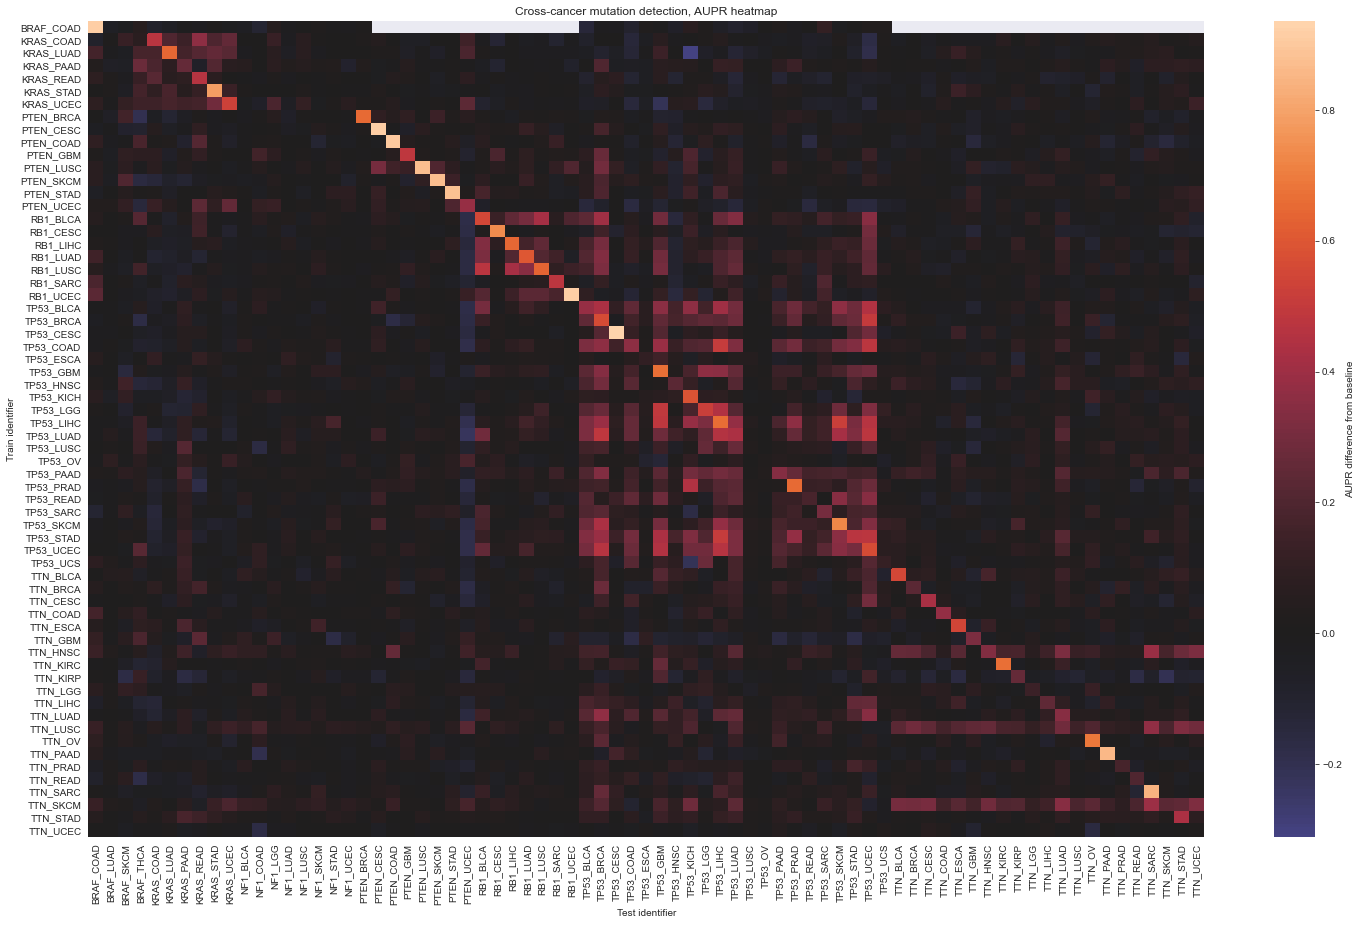

In [126]:
sns.set({'figure.figsize': (25, 15)})
sns.heatmap(heatmap_df, cbar_kws={'label': 'AUPR difference from baseline'}, center=0)
# sns.heatmap(heatmap_df, cbar_kws={'label': 'AUPR difference from baseline'}, cmap=sns.cm.rocket_r)
plt.title('Cross-cancer mutation detection, AUPR heatmap')
plt.xlabel('Test identifier')
plt.ylabel('Train identifier')

We can see that most of the off-diagonal is close to 0 (no improvement against negative control), with the possible exception of TP53 whose classifiers tend to perform well across cancer types. This isn't what we were hoping for (we were hoping to identify new relationships between genes in certain cancer types, but it doesn't look like we're able to do that here, at least for these genes).

Next, we want to try training pan-cancer models for a given gene on all but one cancer type, then testing on the held out cancer type, either on the same gene or different genes. The idea is that the pan-cancer models will benefit from additional data, but combining multiple cancers may also wash out cancer type-specific signals.

In [8]:
pan_cross_cancer_dir = os.path.join(cfg.results_dir, 'pan_cross_cancer', 'pan_cross_cancer')
pan_cross_cancer_df = au.load_prediction_results_cc(pan_cross_cancer_dir, 'pan_cross_cancer')
print(pan_cross_cancer_df.shape)
pan_cross_cancer_df.head()

(1584, 8)


,auroc,aupr,train_gene,test_identifier,signal,seed,data_type,experiment
0,0.91543,0.530930,RB1,KRAS_COAD,shuffled,42,train,pan_cross_cancer
1,0.49109,0.463860,RB1,KRAS_COAD,shuffled,42,test,pan_cross_cancer
2,0.48823,0.077754,RB1,KRAS_COAD,shuffled,42,cv,pan_cross_cancer
0,0.81182,0.348820,NF1,ATM_COAD,signal,42,train,pan_cross_cancer
1,0.47958,0.069659,NF1,ATM_COAD,signal,42,test,pan_cross_cancer


Text(0.5, 1.0, 'Train pancancer/test cross-cancer, same train/test gene highlighted')

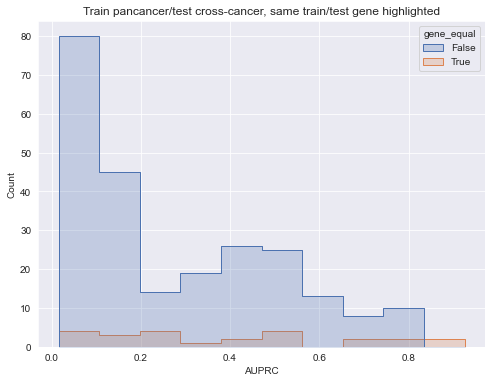

In [9]:
pan_cross_cancer_df['gene_equal'] = (pan_cross_cancer_df.train_gene ==
                                     pan_cross_cancer_df.test_identifier.str.split('_', expand=True)[0])

sns.set({'figure.figsize': (8, 6)})
sns.histplot(data=pan_cross_cancer_df[(pan_cross_cancer_df.signal == 'signal') &
                                      (pan_cross_cancer_df.data_type == 'test')],
             x='aupr', stat='count', hue='gene_equal', element='step', kde=False)
plt.xlabel('AUPRC')
plt.ylabel('Count')
plt.title('Train pancancer/test cross-cancer, same train/test gene highlighted')

In [10]:
# filter cross-cancer data and make a deep copy
# (this avoids SettingWithCopyError)
heatmap_df, _ = au.heatmap_from_results(pan_cross_cancer_df,
                                        train_pancancer=True,
                                        normalize_control=True,
                                        sorted_ids=sorted_ids)
heatmap_df.iloc[:5, :5]

test_identifier,KRAS_COAD,NRAS_COAD,NRAS_SKCM,NRAS_THCA,BRAF_THCA
train_gene,,,,,
KRAS,0.22955,0.038381,-0.00629,-0.031595,0.22804
HRAS,0.10839,-0.028282,-0.02557,-0.022721,-0.00372
NRAS,-0.05720,0.027781,0.07563,0.070457,-0.04817
BRAF,-0.05191,-0.007373,-0.00278,0.031857,-0.14305
NF1,0.01747,-0.032609,-0.02108,-0.021640,0.01954


Text(88.0, 0.5, 'Train identifier')

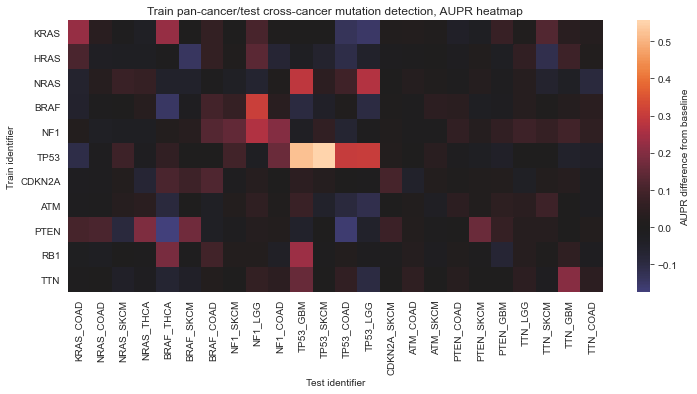

In [11]:
sns.set({'figure.figsize': (12, 5)})
sns.heatmap(heatmap_df, cbar_kws={'label': 'AUPR difference from baseline'}, center=0)
plt.title('Train pan-cancer/test cross-cancer mutation detection, AUPR heatmap')
plt.xlabel('Test identifier')
plt.ylabel('Train identifier')

Compared to the last plot, we can see slightly more off-diagonal signal here, but not much. Again, pan-cancer TP53 classifiers seem to perform the best on TP53, but there are a few other interesting examples (KRAS classifier performs well on some BRAF examples, BRAF classifier performs well on NF1/LGG, etc).

In [12]:
# now do this with only Ras/Raf genes in all cancer types
plot_gene_list = ['KRAS', 'HRAS', 'NRAS', 'BRAF', 'TTN']

pan_cross_cancer_dir = os.path.join(cfg.repo_root, 'pan_cross_cancer_results', 'pan_cross_cancer')
pan_cross_cancer_df = au.load_prediction_results_cc(pan_cross_cancer_dir, 'pan_cross_cancer')
print(pan_cross_cancer_df.shape)
pan_cross_cancer_df.head()

(3342, 8)


,auroc,aupr,train_gene,test_identifier,signal,seed,data_type,experiment
0,0.81182,0.348820,NF1,ATM_COAD,signal,42,train,pan_cross_cancer
1,0.47958,0.069659,NF1,ATM_COAD,signal,42,test,pan_cross_cancer
2,0.68322,0.155740,NF1,ATM_COAD,signal,42,cv,pan_cross_cancer
0,0.51236,0.062820,NF1,TTN_LUSC,shuffled,42,train,pan_cross_cancer
1,0.47875,0.721730,NF1,TTN_LUSC,shuffled,42,test,pan_cross_cancer


In [13]:
# filter cross-cancer data and make a deep copy
# (this avoids SettingWithCopyError)
heatmap_df, _ = au.heatmap_from_results(pan_cross_cancer_df,
                                        plot_gene_list=plot_gene_list,
                                        train_pancancer=True,
                                        normalize_control=True,
                                        sorted_ids=sorted_ids)
print(heatmap_df.shape)
heatmap_df.iloc[:5, :5]

(4, 35)


test_identifier,BRAF_COAD,BRAF_LUAD,BRAF_SKCM,BRAF_THCA,HRAS_HNSC
train_gene,,,,,
KRAS,0.064116,0.012933,0.00149,0.22804,0.325859
HRAS,0.017980,0.042174,-0.08974,0.06150,NaN
NRAS,-0.055855,0.012032,-0.08110,-0.03936,0.001998
BRAF,0.097686,0.020673,-0.08076,-0.04711,0.035395


Text(88.0, 0.5, 'Train identifier')

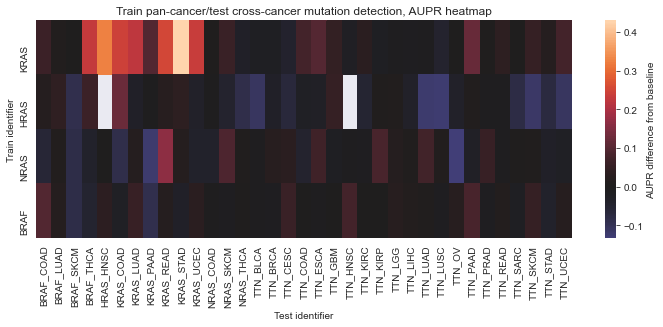

In [14]:
sns.set({'figure.figsize': (12, 4)})
sns.heatmap(heatmap_df, cbar_kws={'label': 'AUPR difference from baseline'}, center=0)
plt.title('Train pan-cancer/test cross-cancer mutation detection, AUPR heatmap')
plt.xlabel('Test identifier')
plt.ylabel('Train identifier')

Expanding our search in the RAS pathway genes to more cancer types, we can see that our pan-cancer KRAS classifier does fairly well at identifying KRAS mutated samples in several held-out cancer types. This matches the conclusion from Greg's work.